# Precipitation Analysis

##### A GWDST project to analyze and visualize precipitation features relevant to gravity waves, notably in terms of variability and extreme analysis.

### Input and data

In [1]:
%matplotlib inline

from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import xarray.ufuncs as xu
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

from dask.distributed import Client

sns.set(context='talk', palette='colorblind', style='ticks')

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:46639 Dashboard: http://127.0.0.1:8787,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


In [3]:
ds = xr.open_mfdataset(sorted(glob('/glade/scratch/mcamron/archive/f.c54120.FWscHIST.f09_f09.gwdst/atm/hist/f.c54120.FWscHIST.f09_f09.gwdst.cam.h1.2002-0[6,7]*')))

ds = ds.sel(lat=slice(-20,20))
ds

<xarray.Dataset>
Dimensions:          (ilev: 71, lat: 42, lev: 70, lon: 288, nbnd: 2, time: 1464)
Coordinates:
  * lat              (lat) float64 -19.32 -18.38 -17.43 -16.49 -15.55 -14.61 ...
  * lon              (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 ...
  * lev              (lev) float64 5.96e-06 9.827e-06 1.62e-05 2.671e-05 ...
  * ilev             (ilev) float64 4.5e-06 7.42e-06 1.223e-05 2.017e-05 ...
  * time             (time) datetime64[ns] 2002-06-01 2002-06-01T00:59:59 ...
Dimensions without coordinates: nbnd
Data variables:
    gw               (time, lat) float64 0.01552 0.01561 0.01569 0.01577 ...
    hyam             (time, lev) float64 5.96e-09 9.827e-09 1.62e-08 ...
    hybm             (time, lev) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    P0               (time) float64 1e+05 1e+05 1e+05 1e+05 1e+05 1e+05 ...
    hyai             (time, ilev) float64 4.5e-09 7.42e-09 1.223e-08 ...
    hybi             (time, ilev) float64 0.0 0.0 0.0 0.0 0.0 0

## Distributions

Importantly, below we began running into concerns regarding potential discretization of precip bins. Upon inspection, the raw data are precise to 8 decimal places and the bulk of the unconverted PRECT distribution remained continuous even up to 100000 bins.

In [4]:
prect = ds.PRECT * 3.6e6  # Converting from m/s to mm/hr
precl = ds.PRECL * 3.6e6
precc = ds.PRECC * 3.6e6

print('Max:       ', prect.values.max(), precl.values.max(), precc.values.max())
print('% Nonzero: ',
      prect.where(prect > 0).notnull().sum().values/prect.size, 
      precl.where(precl > 0).notnull().sum().values/precl.size,
      precc.where(precc > 0).notnull().sum().values/precc.size)

Max:        21.338 18.9716 3.99449
% Nonzero:  0.930671318884 0.930490445742 0.496180713671


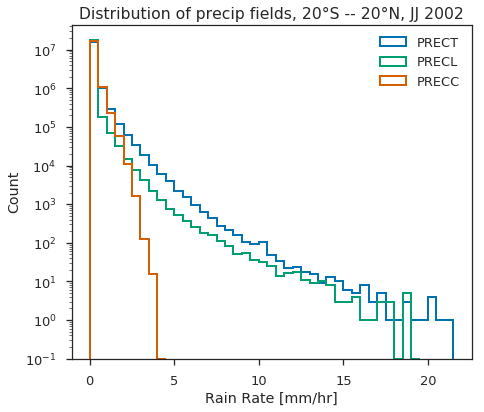

In [5]:
f, ax = plt.subplots(figsize=(7, 6))
prect.plot.hist(ax=ax, log=True, bins=np.arange(0, prect.values.max().round()+1, 0.5), histtype='step', linewidth=2, label='PRECT')
precl.plot.hist(ax=ax, log=True, bins=np.arange(0, precl.values.max().round()+1, 0.5), histtype='step', linewidth=2, label='PRECL')
precc.plot.hist(ax=ax, log=True, bins=np.arange(0, precc.values.max().round()+1, 0.5), histtype='step', linewidth=2, label='PRECC')
ax.legend()
ax.set_xlabel('Rain Rate [mm/hr]')
ax.set_title('Distribution of precip fields, 20' + u'\N{DEGREE SIGN}' + 'S -- 20' + u'\N{DEGREE SIGN}' + 'N, JJ 2002')

plt.tight_layout()
f.savefig('../figures/precip/dist_PREC.png')

Here I inspected histograms excluding zeroes. However, at these scales, only the lowest PRECC bin was very minorly affected.

### Rain-rate squared
For lognormal wave comparison

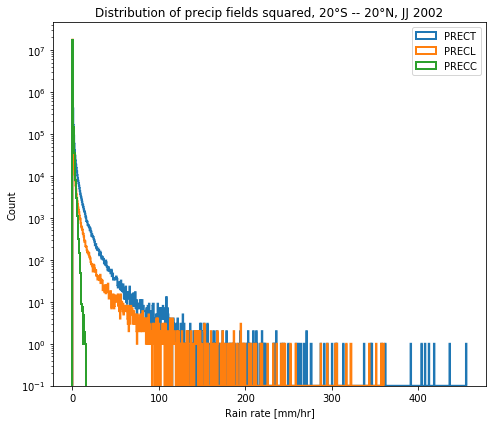

In [16]:
f, ax = plt.subplots(figsize=(7, 6))
xu.square(prect).plot.hist(ax=ax, log=True, bins=np.arange(0, xu.square(prect).values.max().round()+1, 0.5), histtype='step', linewidth=2, label='PRECT')
xu.square(precl).plot.hist(ax=ax, log=True, bins=np.arange(0, xu.square(precl).values.max().round()+1, 0.5), histtype='step', linewidth=2, label='PRECL')
xu.square(precc).plot.hist(ax=ax, log=True, bins=np.arange(0, xu.square(precc).values.max().round()+1, 0.5), histtype='step', linewidth=2, label='PRECC')

ax.legend()
ax.set_xlabel('Rain rate [mm/hr]')
ax.set_title('Distribution of precip fields squared, 20' + u'\N{DEGREE SIGN}' + 'S -- 20' + u'\N{DEGREE SIGN}' + 'N, JJ 2002')

plt.tight_layout()

f.savefig('../figures/precip/dist_PREC-squared.png')

## Percentile analysis
Here we will investigate the fractional contribution of our more extreme rain events.

### PRECT

In [7]:
prect_mean = prect.mean().values

prect_90 = np.percentile(prect.values, 90)
prect_90_tot = prect.values[np.where(prect.values > prect_90)].sum() / prect.values.sum()

prect_99 = np.percentile(prect.values, 99)
prect_99_tot = prect.values[np.where(prect.values > prect_99)].sum() / prect.values.sum()

prect_999 = np.percentile(prect.values, 99.9)
prect_999_tot = prect.values[np.where(prect.values > prect_999)].sum() / prect.values.sum()

print('Mean:       ', str(prect_mean))
print('Top 10%:    ', str(prect_90), ' / ', str(prect_90_tot*100), '%')
print('Top 1%:     ', str(prect_99), ' / ', str(prect_99_tot*100), '%')
print('Top 0.1%:   ', str(prect_999), ' / ', str(prect_999_tot*100), '%')

Mean:        0.15890029072761536
Top 10%:     0.459293478727  /  62.8225326538 %
Top 1%:      1.80849817753  /  17.229051888 %
Top 0.1%:    3.94447354031  /  3.27519848943 %


`np.sort(prect.values.flatten())[int(0.9*prect.values.flatten().size)]` was used to manually verify this was providing the desired statistics. Statistics without zeroes barely increased all of the statistics.

### PRECL

In [8]:
precl_mean = precl.values.mean()

precl_90 = np.percentile(precl.values, 90)
precl_90_tot = precl.values[np.where(precl.values > precl_90)].sum() / precl.values.sum()

precl_99 = np.percentile(precl.values, 99)
precl_99_tot = precl.values[np.where(precl.values > precl_99)].sum() / precl.values.sum()

precl_999 = np.percentile(precl.values, 99.9)
precl_999_tot = precl.values[np.where(precl.values > precl_999)].sum() / precl.values.sum()

print('Mean:       '+str(precl_mean)+' (including zeroes)')
print('Top 10%:    '+str(precl_90)+' / '+str(precl_90_tot*100)+'%')
print('Top 1%:     '+str(precl_99)+' / '+str(precl_99_tot*100)+'%')
print('Top 0.1%:   '+str(precl_999)+' / '+str(precl_999_tot*100)+'%')

Mean:       0.0313859 (including zeroes)
Top 10%:    0.0115808000788 / 96.5787410736%
Top 1%:     0.833416520953 / 49.7842252254%
Top 0.1%:   2.52427373934 / 11.586920172%


### PRECC

In [9]:
precc_mean = precc.values.mean()

precc_90 = np.percentile(precc.values, 90)
precc_90_tot = precc.values[np.where(precc.values > precc_90)].sum() / precc.values.sum()

precc_99 = np.percentile(precc.values, 99)
precc_99_tot = precc.values[np.where(precc.values > precc_99)].sum() / precc.values.sum()

precc_999 = np.percentile(precc.values, 99.9)
precc_999_tot = precc.values[np.where(precc.values > precc_999)].sum() / precc.values.sum()

print('Mean:       '+str(precc_mean)+' (including zeroes)')
print('Top 10%:    '+str(precc_90)+' / '+str(precc_90_tot*100)+'%')
print('Top 1%:     '+str(precc_99)+' / '+str(precc_99_tot*100)+'%')
print('Top 0.1%:   '+str(precc_999)+' / '+str(precc_999_tot*100)+'%')

Mean:       0.127514 (including zeroes)
Top 10%:    0.425026524067 / 58.5812568665%
Top 1%:     1.17825620294 / 11.7955990136%
Top 0.1%:   1.91503957653 / 1.70028582215%


#### Non-zero analysis
Really only showed any difference in PRECC. Excluded elsewhere.

In [10]:
precc_mean = precc.where(precc > 0).mean(skipna=True).values

precc_90 = np.nanpercentile(precc.where(precc > 0).values, 90)
precc_90_tot = precc.values[np.where(precc.values > precc_90)].sum() / precc.values.sum()

precc_99 = np.nanpercentile(precc.where(precc > 0).values, 99)
precc_99_tot = precc.values[np.where(precc.values > precc_99)].sum() / precc.values.sum()

precc_999 = np.nanpercentile(precc.where(precc > 0).values, 99.9)
precc_999_tot = precc.values[np.where(precc.values > precc_999)].sum() / precc.values.sum()

print('Mean:       '+str(precc_mean)+' (including zeroes)')
print('Top 10%:    '+str(precc_90)+' / '+str(precc_90_tot*100)+'%')
print('Top 1%:     '+str(precc_99)+' / '+str(precc_99_tot*100)+'%')
print('Top 0.1%:   '+str(precc_999)+' / '+str(precc_999_tot*100)+'%')

Mean:       0.25699180364608765 (including zeroes)
Top 10%:    0.645346498489 / 37.939041853%
Top 1%:     1.42163098335 / 6.71574920416%
Top 0.1%:   2.09843558455 / 0.911235902458%


## Maps

### Initial Maps

In [11]:
print(precc.mean(dim='time').max().values, precl.mean(dim='time').max().values, prect.mean(dim='time').max().values)

0.7636562585830688 0.6954289674758911 1.257091999053955


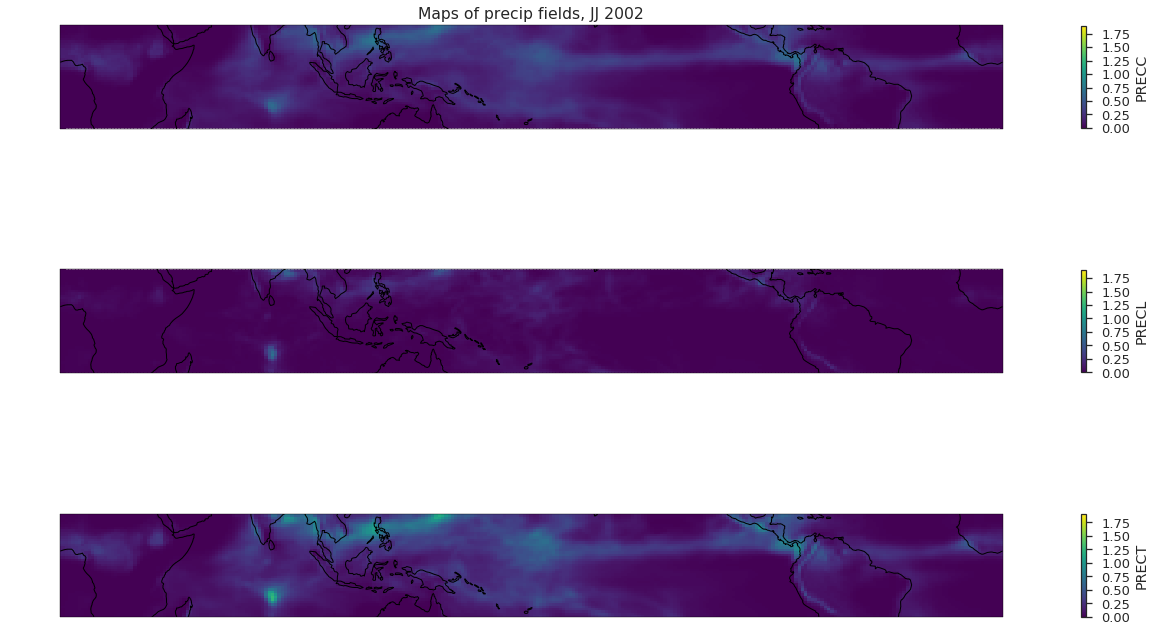

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, squeeze=True, figsize=(18,12), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
p = precc.mean(dim='time').plot(ax=ax1, transform=ccrs.PlateCarree(), vmax=1.9, cbar_kwargs=dict(shrink=0.3, pad=0.025))#, cmap=sns.color_palette("Greens"))
q = precl.mean(dim='time').plot(ax=ax2, transform=ccrs.PlateCarree(), vmax=1.9, cbar_kwargs=dict(shrink=0.3, pad=0.025))#, cmap=sns.color_palette("Greens"))
r = prect.mean(dim='time').plot(ax=ax3, transform=ccrs.PlateCarree(), vmax=1.9, cbar_kwargs=dict(shrink=0.3, pad=0.025))#, cmap=sns.color_palette("Greens"))

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()

ax1.set_title('Maps of precip fields, JJ 2002')

plt.tight_layout(h_pad=0)

f.savefig('../figures/precip/precip_maps.png')

### Contribution of PRECC to PRECT

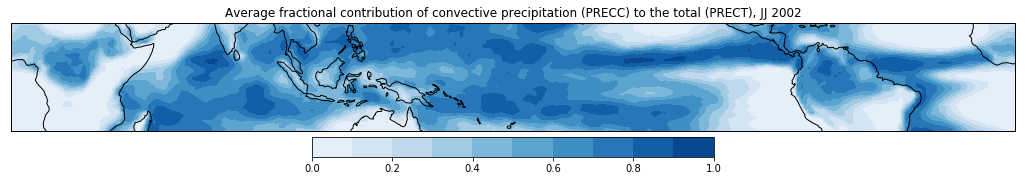

In [17]:
pcfrac = precc.where(prect > 0) / prect.where(prect > 0)

f, ax = plt.subplots(figsize=(18, 4), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
p = pcfrac.mean(dim='time').plot.contourf(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, levels=11, colors=sns.color_palette("Blues", 10))
ax.coastlines()
cbar = plt.colorbar(p, ax=ax, orientation='horizontal', shrink=0.4, pad=0.025)

ax.set_title('Average fractional contribution of convective precipitation (PRECC) to the total (PRECT), JJ 2002')

f.savefig('../figures/precip/pcfrac.png')

In [14]:
pcfrac.where(pcfrac > 0.5).notnull().sum().values / pcfrac.notnull().sum().values

0.50515192374366491

### Locations of high-intensity events

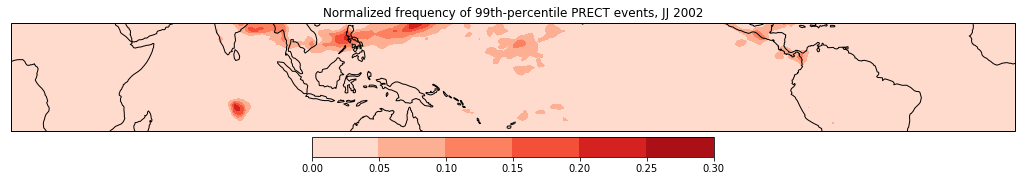

In [15]:
ptfreq = prect.where(prect > prect_99).notnull().sum(dim='time') / prect.time.size
f, ax = plt.subplots(figsize=(18, 4), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
p = ptfreq.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, colors=sns.color_palette("Reds"))
ax.coastlines()
cbar = plt.colorbar(p, ax=ax, orientation='horizontal', shrink=0.4, pad=0.025)

ax.set_title('Normalized frequency of 99th-percentile PRECT events, JJ 2002')

f.savefig('../figures/precip/pcfreq.png')